In [1]:
import collections
import itertools
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
import random

#### ...train.txt 내용
1 Mary moved to the bathroom.<br>
2 John went to the hallway.<br>
3 Where is Mary? (tab)bathroom(tab)1

In [7]:
def get_data(infile):
    stories, questions, answers = [], [], []
    story_text = []
    fin = open(infile, "r") 
    for line in fin:
        line = line.strip()                # strip() : 양쪽 끝에 있는 공백, \t, \n 제거
        lno, text = line.split(" ", 1)     # 맨 앞의 라인 번호 분리
        if "\t" in text:                   # 세 번째 문장에는 \t가 두개 있음.
            question, answer, _ = text.split("\t")
            stories.append(story_text)     # 처음 두 문장
            questions.append(question)     # 세 번째 문장의 질문
            answers.append(answer)         # 세 번째 문장의 답변
            story_text = []
        else:
            story_text.append(text)        # 처음 두 문장이 들어감
    fin.close()
    return stories, questions, answers

# get the data
data_train = get_data("qa1_single-supporting-fact_train.txt")
data_test = get_data("qa1_single-supporting-fact_test.txt")

print("Train observations:",len(data_train[0]),"Test observations:", len(data_test[0]))

Train observations: 10000 Test observations: 1000


첫 번째 에피소딕 스토리, 질문(Q), 답변(A) 확인

In [11]:
print("스토리 = ", data_train[0][0])
print("질  문 = ", data_train[1][0])
print("답  변 = ", data_train[2][0])

스토리 =  ['Mary moved to the bathroom.', 'John went to the hallway.']
질  문 =  Where is Mary? 
답  변 =  bathroom


#### Building Vocab dictionary from Train & Test data

In [13]:
dictnry = collections.Counter()
for stories, questions, answers in [data_train, data_test]:
    for story in stories:
        for sent in story:
            for word in nltk.word_tokenize(sent):
                dictnry[word.lower()] += 1
                
    for question in questions:
        for word in nltk.word_tokenize(question):
            dictnry[word.lower()] += 1
            
    for answer in answers:
        for word in nltk.word_tokenize(answer):
            dictnry[word.lower()] += 1

word2indx = {w:(i+1) for i,(w,_) in enumerate(dictnry.most_common())}

word2indx["PAD"] = 0
indx2word = {v:k for k,v in word2indx.items()}

vocab_size = len(word2indx)
print("vocabulary size:",len(word2indx))
print(word2indx)

vocabulary size: 22
{'to': 1, 'the': 2, '.': 3, 'where': 4, 'is': 5, '?': 6, 'went': 7, 'john': 8, 'sandra': 9, 'mary': 10, 'daniel': 11, 'bathroom': 12, 'office': 13, 'garden': 14, 'hallway': 15, 'kitchen': 16, 'bedroom': 17, 'journeyed': 18, 'travelled': 19, 'back': 20, 'moved': 21, 'PAD': 0}


#### compute max sequence length for each entity

In [14]:
story_maxlen = 0
question_maxlen = 0

for stories, questions, answers in [data_train, data_test]:
    for story in stories:
        story_len = 0
        for sent in story:
            swords = nltk.word_tokenize(sent)
            story_len += len(swords)
        if story_len > story_maxlen:
            story_maxlen = story_len
            
    for question in questions:
        question_len = len(nltk.word_tokenize(question))
        if question_len > question_maxlen:
            question_maxlen = question_len
            
print ("Story maximum length:",story_maxlen,"Question maximum length:",question_maxlen)

Story maximum length: 14 Question maximum length: 4


In [16]:
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, Permute
from keras.layers.embeddings import Embedding
from keras.layers.merge import add, concatenate, dot
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

Using TensorFlow backend.


#### Converting data into Vectorized form
Xstrain[0] = [0,0,8,21,1,2,12,3,9,7,1,2,13,3]   - 14개<br>
Xqtrain[0] = [4,5,8,6] - 4개<br>
Ytrain[0] = [0,0,0,0,...0,1,0,0,0,]   - 22개의 one-hot

In [28]:
# list of list 연습
for story, question, answer in zip(stories, questions, answers):
    xs = [[word2indx[w.lower()] for w in nltk.word_tokenize(s)] for s in story]
    print(story)
    print(xs)
    xs = list(itertools.chain.from_iterable(xs))
    print(xs)
    break

['John travelled to the hallway.', 'Mary journeyed to the bathroom.']
[[8, 19, 1, 2, 15, 3], [10, 18, 1, 2, 12, 3]]
[8, 19, 1, 2, 15, 3, 10, 18, 1, 2, 12, 3]


In [31]:
def data_vectorization(data, word2indx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [[word2indx[w.lower()] for w in nltk.word_tokenize(s)] for s in story]
        xs = list(itertools.chain.from_iterable(xs))   # 2개 스토리를 하나로 합친다
        xq = [word2indx[w.lower()] for w in nltk.word_tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2indx[answer.lower()])
        
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           np_utils.to_categorical(Y, num_classes=len(word2indx))

Xstrain, Xqtrain, Ytrain = data_vectorization(data_train, word2indx, story_maxlen, question_maxlen)
Xstest, Xqtest, Ytest = data_vectorization(data_test, word2indx, story_maxlen, question_maxlen)

print("Train story",Xstrain.shape,"Train question", Xqtrain.shape,"Train answer", Ytrain.shape)
print( "Test story",Xstest.shape, "Test question",Xqtest.shape, "Test answer",Ytest.shape)

Train story (10000, 14) Train question (10000, 4) Train answer (10000, 22)
Test story (1000, 14) Test question (1000, 4) Test answer (1000, 22)


In [32]:
Xstrain[0]

array([ 0,  0, 10, 21,  1,  2, 12,  3,  8,  7,  1,  2, 15,  3])

#### Model Parameters

In [46]:
EMBEDDING_SIZE = 128
LATENT_SIZE = 64
BATCH_SIZE = 64
NUM_EPOCHS = 40

# Inputs
story_input = Input(shape=(story_maxlen,))
question_input = Input(shape=(question_maxlen,))

# Story encoder embedding
story_encoder = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_SIZE,
                         input_length=story_maxlen)(story_input)
story_encoder = Dropout(rate = 0.2)(story_encoder)

# Question encoder embedding
question_encoder = Embedding(input_dim=vocab_size,output_dim=EMBEDDING_SIZE,
                            input_length=question_maxlen)(question_input)
question_encoder = Dropout(rate = 0.3)(question_encoder)

# Match between story and question
match = dot([story_encoder, question_encoder], axes=[2,2])

# Encode story into vector space of question
story_encoder_c = Embedding(input_dim=vocab_size,output_dim=question_maxlen,
                           input_length=story_maxlen)(story_input)
story_encoder_c = Dropout(rate = 0.3)(story_encoder_c)

# Combine match and story vectors
response = add([match, story_encoder_c])
response = Permute((2, 1))(response)

# Combine response and question vectors to answers space
answer = concatenate([response, question_encoder], axis=-1)
answer = LSTM(LATENT_SIZE)(answer)
answer = Dropout(rate = 0.2)(answer)
answer = Dense(vocab_size)(answer)
output = Activation("softmax")(answer)

model = Model(inputs=[story_input, question_input], outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])
print (model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 14)           0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 14, 128)      2816        input_15[0][0]                   
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 4, 128)       2816        input_16[0][0]                   
__________________________________________________________________________________________________
dropout_19

#### Model Training

In [47]:
history = model.fit([Xstrain, Xqtrain], [Ytrain], batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, validation_data=([Xstest, Xqtest], [Ytest]))

Instructions for updating:
Use tf.cast instead.
Train on 10000 samples, validate on 1000 samples
Epoch 1/40
10000/10000 [==============================] - 6s 643us/step - loss: 1.9876 - acc: 0.2044 - val_loss: 1.6515 - val_acc: 0.2970
Epoch 2/40
10000/10000 [==============================] - 2s 233us/step - loss: 1.6603 - acc: 0.2660 - val_loss: 1.6346 - val_acc: 0.2670
Epoch 3/40
10000/10000 [==============================] - 2s 230us/step - loss: 1.5537 - acc: 0.3859 - val_loss: 1.4456 - val_acc: 0.4930
Epoch 4/40
10000/10000 [==============================] - 2s 235us/step - loss: 1.4035 - acc: 0.5068 - val_loss: 1.3728 - val_acc: 0.5270
Epoch 5/40
10000/10000 [==============================] - 2s 232us/step - loss: 1.3445 - acc: 0.5204 - val_loss: 1.3469 - val_acc: 0.5270
Epoch 6/40
10000/10000 [==============================] - 2s 235us/step - loss: 1.3074 - acc: 0.5237 - val_loss: 1.3168 - val_acc: 0.5210
Epoch 7/40
10000/10000 [==============================] - 2s 232us/step - l

#### plot accuracy and loss plot

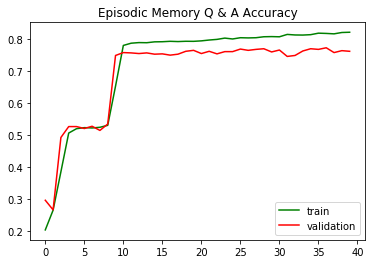

In [48]:
plt.title("Episodic Memory Q & A Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="r", label="validation")
plt.legend(loc="best")
plt.show()

#### get predictions of labels

In [55]:
from sklearn.metrics import accuracy_score
ytest = np.argmax(Ytest, axis=1)
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)
accuracy_score(ytest, ytest_)

0.762

#### Select Random questions and predict answers

In [56]:
NUM_DISPLAY = 10
   
for i in random.sample(range(Xstest.shape[0]),NUM_DISPLAY):
    story = " ".join([indx2word[x] for x in Xstest[i].tolist() if x != 0])
    question = " ".join([indx2word[x] for x in Xqtest[i].tolist()])
    label = indx2word[ytest[i]]
    prediction = indx2word[ytest_[i]]
    print(story, question, label, prediction)

sandra went to the garden . john went to the garden . where is mary ? garden bathroom
mary moved to the garden . daniel went back to the office . where is mary ? garden garden
mary journeyed to the bedroom . sandra travelled to the hallway . where is john ? bedroom bedroom
mary went to the kitchen . john journeyed to the kitchen . where is mary ? kitchen kitchen
john journeyed to the hallway . john journeyed to the bedroom . where is john ? bedroom bedroom
daniel went back to the hallway . mary went to the hallway . where is mary ? hallway hallway
john journeyed to the bedroom . john went back to the hallway . where is mary ? garden bathroom
sandra moved to the garden . daniel went back to the bedroom . where is sandra ? garden garden
mary went to the bathroom . sandra moved to the garden . where is sandra ? garden garden
john went back to the bathroom . daniel moved to the hallway . where is daniel ? hallway hallway


In [61]:
story

'john went back to the bathroom . daniel moved to the hallway .'

In [62]:
question

'where is daniel ?'